## Data Exploration ##

In this first section we explore the data downloaded from https://www.kaggle.com/c/mercari-price-suggestion-challenge/data

**Import Section**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import operator
import plotly.express as px
import sys
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
np.set_printoptions(threshold=sys.maxsize) # Print full np.array
pd.set_option('display.max_columns', None) # Display all columns in a dataframe

**Read the Data**

Take care the the file is a tsv one.

In [3]:
# Read the data into a dataframe

ddf=pd.read_csv('../data/train.tsv', sep='\t')
ddf.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
ddf.shape

(1482535, 8)

In [5]:
# Number of unique elements against total

print(ddf['train_id'].nunique(), len(ddf)) # the result is that train_id is unique

1482535 1482535


In [6]:
# Type of each column and number of non-null elements

ddf.info() # the result is that ategory_name, item_description and brand_name have nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [7]:
# Let's convert train_id, shipping and item_condition_id columns to non-numeric, since they are not numeric,
# in order to get a proper analysis

def convertToNonNumeric(df, columns):
    """ Convert columns to non-numeric

    :param df: initial dataframe
    :param columns: list of columns to be converted
    :return: processed dataframe
    """
    for column in columns:
        df[column] = df[column].apply(lambda x: "{:.0f}".format(x) if not pd.isnull(x) else x)
    return df

ddf = convertToNonNumeric(ddf, ['train_id', 'shipping', 'item_condition_id'])

ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  object 
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  object 
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  object 
 7   item_description   1482531 non-null  object 
dtypes: float64(1), object(7)
memory usage: 90.5+ MB


In [8]:
# Statistics of the numerical column: price. We will see further the statistics per category.

pd.set_option('display.float_format', lambda x: '%.2f' % x)
ddf.describe()

,price
count,1482535.00
mean,26.74
std,38.59
min,0.00
25%,10.00
50%,17.00
75%,29.00
max,2009.00


In [29]:
# Summarize non-numeric columns (all except for price)

ddf.describe(exclude={'float64'})

,train_id,name,item_condition_id,category_name,brand_name,shipping,item_description
count,1482535,1482535,1482535,1476208,849853,1482535,1482531
unique,1482535,1225273,5,1287,4809,2,1281426
top,483808,Bundle,1,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,0,No description yet
freq,1,2232,640549,60177,54088,819435,82489


In [10]:
# Columns with null elements

ddf.columns[df.isnull().any()] # The result is that 'category_name', 'brand_name', 'item_description' have nulls

Index(['category_name', 'brand_name', 'item_description'], dtype='object')

In [11]:
# Number of items without category, we will remove them when building the models

ddf[ddf['category_name'].isnull()].count()['train_id']

6327

In [12]:
# Number of unique elements per column

ddf.nunique()

train_id             1482535
name                 1225273
item_condition_id          5
category_name           1287
brand_name              4809
price                    828
shipping                   2
item_description     1281426
dtype: int64

In [13]:
# We separate category hierarchies, creating the corresponding columns

ddf = ddf.join(ddf['category_name'].str.split('/', expand=True).add_prefix('cat_').fillna(np.nan))
ddf.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_0,cat_1,cat_2,cat_3,cat_4
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet,Men,Tops,T-shirts,NaN,NaN
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,NaN,NaN
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,NaN,NaN
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,NaN,NaN
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,NaN,NaN


In [14]:
# Unique elements of the new dataframe (ddf) that contains the unrolled categories

ddf.nunique()

train_id             1482535
name                 1225273
item_condition_id          5
category_name           1287
brand_name              4809
price                    828
shipping                   2
item_description     1281426
cat_0                     10
cat_1                    113
cat_2                    870
cat_3                      6
cat_4                      2
dtype: int64

In [15]:
# Number of items per level 0 categories

ddf.groupby(["cat_0"])["train_id"].count().sort_values(ascending=False)

cat_0
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Name: train_id, dtype: int64

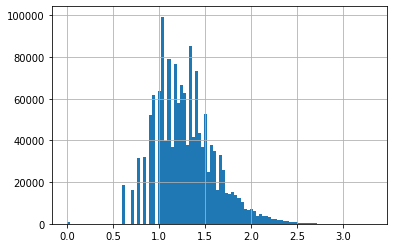

In [16]:
# Logarithmic (base 10) histogram of items per price

(np.log10(ddf.price + 1)).hist(bins=100) # We can see the scatter is quite limited

In [17]:
# We create a new column for the logarithm of price

ddf['price_log'] = np.log10(ddf.price + 1)

Text(0, 0.5, 'Number')

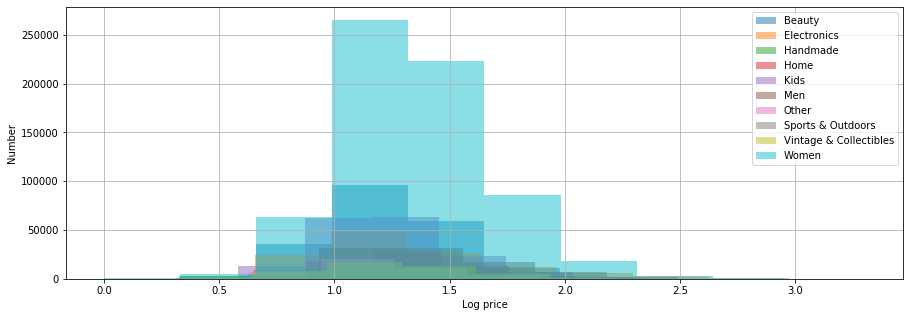

In [18]:
# Logarithmic histogram of price considering level 0 categories

X, y = ddf['cat_0'], ddf.price_log
inds = y.groupby(X).std().sort_values().index[:]
inds = X.isin(inds)
X, y = X[inds], y[inds]
fig = plt.figure(figsize = (15,5))
ax = fig.gca()
y.groupby(X).apply(lambda x: x.hist(alpha=.5, label=x.name, ax=ax))
plt.legend()
plt.xlabel('Log price')
plt.ylabel('Number')

In [19]:
# Statistics of price per level 0 categories

ddf.groupby(["cat_0"]).agg({'price': ['mean', 'min', 'max']})

price             
                        mean  min     max
cat_0                                    
Beauty                 19.67 0.00 2000.00
Electronics            35.17 0.00 1909.00
Handmade               18.16 0.00 1750.00
Home                   24.54 0.00  848.00
Kids                   20.64 0.00  809.00
Men                    34.71 0.00 1309.00
Other                  20.81 0.00 1400.00
Sports & Outdoors      25.53 0.00  915.00
Vintage & Collectibles 27.34 0.00 1709.00
Women                  28.89 0.00 2009.00

In [20]:
# Get articles with price=0 per level 0 categories, we will discard them when building the models

ddf[ddf.price == 0].groupby(["cat_0"])["price"].count().sort_values(ascending=False)

cat_0
Women                     395
Kids                      134
Beauty                    103
Men                        71
Electronics                58
Home                       40
Other                      22
Sports & Outdoors          20
Vintage & Collectibles     11
Handmade                    7
Name: price, dtype: int64

In [21]:
# Let's see how many items we have per level 2 category
# The level 2 category is the deepest one still defined for all of the items

grouped = ddf.groupby('cat_2', sort=False).count()['train_id'].sort_values(ascending=False).to_frame(name = 'total')
grouped

,total
cat_2,
"Pants, Tights, Leggings",60177
Other,50224
Face,50171
T-Shirts,46380
Shoes,32168
...,...
International Publications,1
St Patricks,1
Bathroom,1


In [22]:
# Let's limit ourselves to the level 2 categories with at least 10,000 items, for statistics purposes

gr = grouped[grouped.total > 10000]

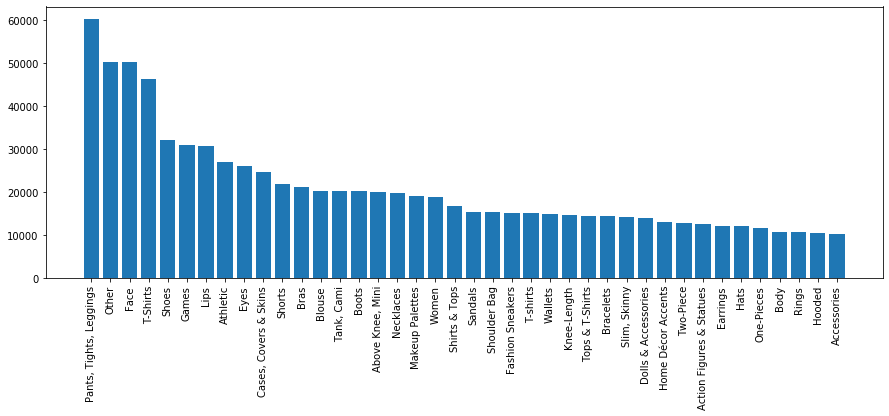

In [23]:
# We build a bar histogram, ordering descendently by the number of items
# "Other" is the 2nd level 2 category in volume 

fig = plt.figure(figsize = (15,5))
x = np.arange(gr.count()[0])
plt.bar(x, gr.total.to_numpy())
plt.xticks(x, gr.index.to_numpy(), rotation='vertical')
plt.show()

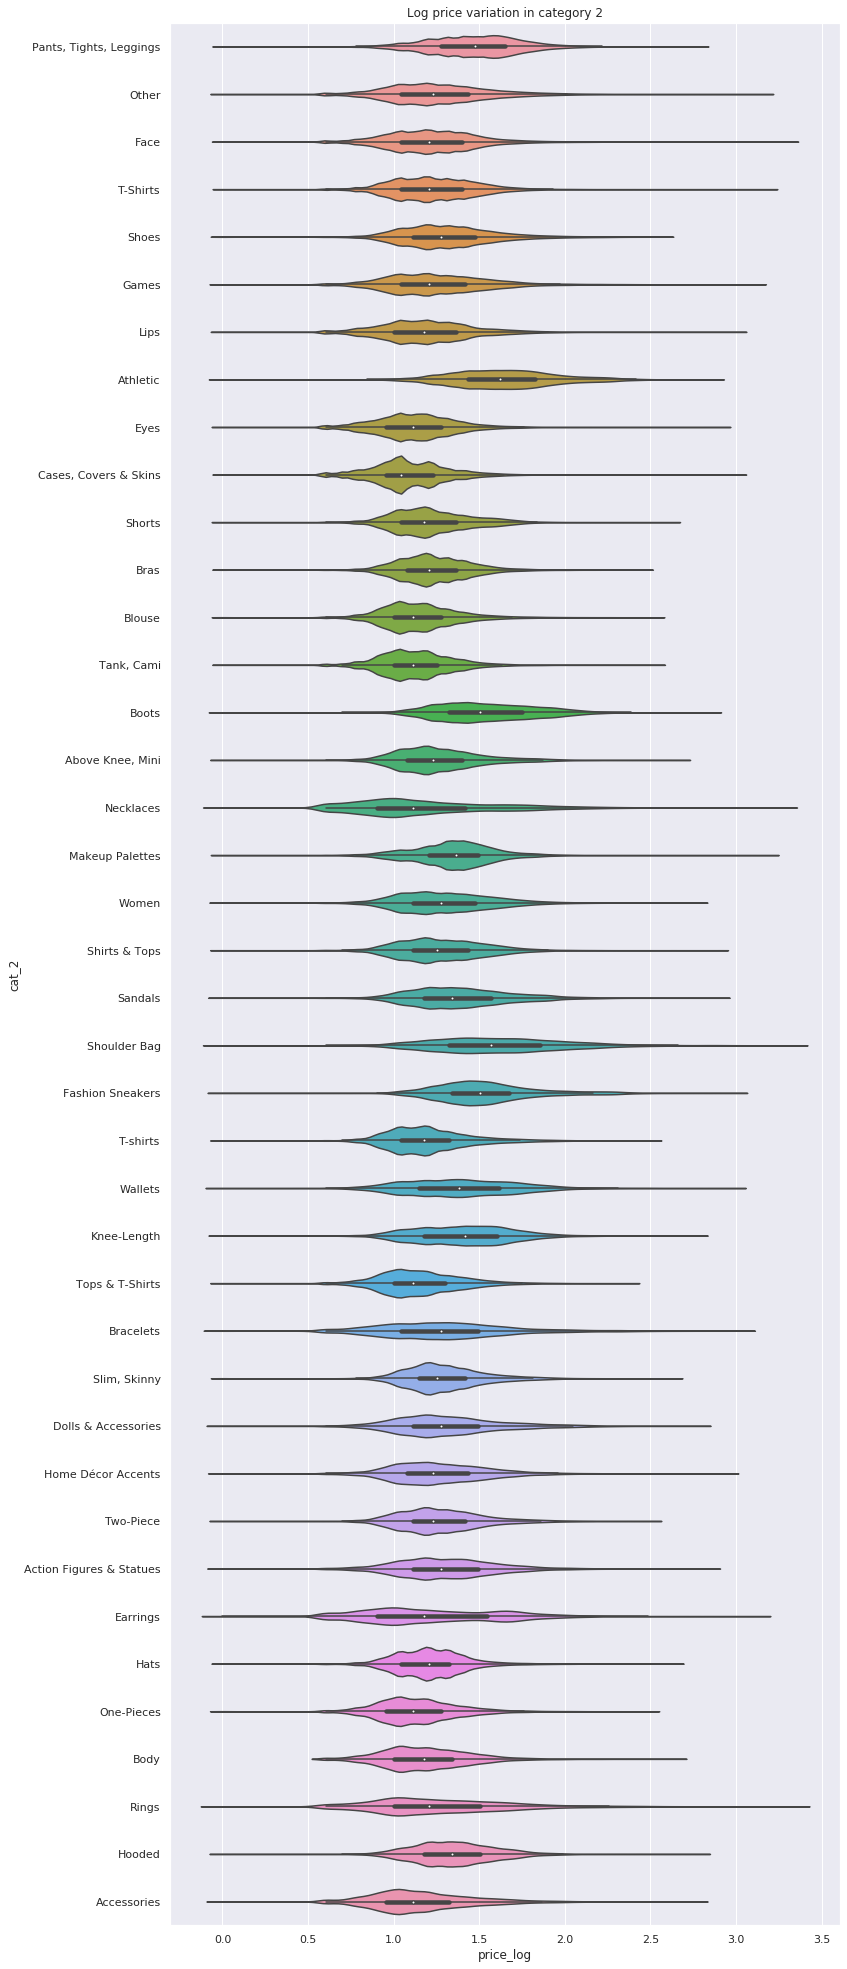

In [28]:
# Log price variation in level 2 category, we use "violin plots" that has the advantage of combining
# the box and kernel density plots

cat_order = gr.index.to_numpy()
sns.set(rc={'figure.figsize':(12,35)})
v = sns.violinplot(y = "cat_2", x = "price_log", data = ddf[ddf.cat_2.isin(cat_order)], order = cat_order, orient="h")
plt.title('Log price variation in category 2')
plt.show() # The median and interquartile range are quite limited among the different categories